In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

In [1087]:
#FUNCTIONS
def resid_plot(model) :
    """Plots residual plot and returns residuals and fitted values"""
    e = model.resid
    yhat = model.fittedvalues
    fig, ax = plt.subplots()
    sns.residplot(yhat, e, lowess = True, scatter_kws = {'alpha': 0.25})
    ax.set_xlabel('yhat')
    ax.set_ylabel('e')
    plt.show()
    return e, yhat
def cooks_plot(model) :
    """Plots Cook's Distance plot & returns Cook's distances"""
    cooks = OLSInfluence(model).summary_frame()['cooks_d']
    fig, ax = plt.subplots()
    ax.set_ylim(0, np.max(cooks) * 1.25)
    for a, b in zip(np.array(cooks.index), cooks.values) :
        ax.plot([a, a], [0, b], c = 'k')
    plt.show()
    return cooks
def stepwise_by_pval(data, y_col, thresh = 0.05, data_in = True) :
    """Function to perform stepwise regression at removing explanatory variables at p-value threshold of 0.05"""
    dropped_list = list()
    if data_in == False :
        y = y_col
        X = sm.add_constant(data)
    else :
        y = data[y_col]
        x_cols = list(data.columns)
        x_cols.remove(y_col)
        X = sm.add_constant(data[x_cols])
    while True :
        lm = sm.OLS(y, X).fit()
        adj_r2 = lm.rsquared_adj
        pvals = lm.pvalues
        pvals = pvals[pvals.index != 'const']
        if pvals.max() > thresh :
            drop_name = pvals.idxmax()
            X = X.drop(drop_name, axis = 1)
            dropped_list.append((drop_name, pvals.loc[drop_name], adj_r2))
            continue
        else :
            break
    return (lm, lm.params, np.sqrt(lm.scale), dropped_list)
def stepwise_by_aic(data, y_col) :
    """Function to perform stepwise regression by minimizing AIC"""
    y = data[y_col]
    x_cols = list(data.columns)
    x_cols.remove(y_col)
    X = sm.add_constant(data[x_cols])
    lm = sm.OLS(y, X).fit()
    aic = lm.aic
    progress_aic = {}
    progress_aic[lm.aic] = x_cols
    while True :
        new_low_aic_cols = 0
        for i in range(len(x_cols)) :
            mask = np.ones(len(x_cols))
            mask[i] = False
            new_x_cols = [c for c, m in zip(x_cols, mask) if m]
            lm_new = sm.OLS(y, sm.add_constant(data[new_x_cols])).fit()
            if lm_new.aic < aic :
                lm_report = lm_new
                aic = lm_report.aic
                new_low_aic_cols = new_x_cols
        if new_low_aic_cols == 0 :
            break
        else :
            x_cols = new_low_aic_cols
            progress_aic[aic] = new_low_aic_cols
    return lm_report, lm_report.params, np.sqrt(lm_report.scale), progress_aic
def get_VIFs(model, model_x_cols) :
    """Print VIF values"""
    for i, x in enumerate(model_x_cols) :
        print ('{}: {:.3f}'.format(x,variance_inflation_factor(model.model.exog, i+1)))
def check_for_transform(data) :
    _, lam = stats.boxcox(data)
    if lam < -2.5 :
        print ('Your lambda is reeeeeally low:', lam)
    elif lam < -1.5 :
        print ('1/y**2: {:.3f}'.format(lam))
    elif lam < -0.75 :
        print ('1/y: {:.3f}'.format(lam))
    elif lam < -0.25 :
        print ('1/sqrt(y): {:.3f}'.format(lam))
    elif lam < 0.25 :
        print ('log(y): {:.3f}'.format(lam))
    elif lam < 0.75 :
        print ('sqrt(y): {:.3f}'.format(lam))
    elif lam < 1.5 :
        print ('y: {:.3f}'.format(lam))
    elif lam < 2.5 :
        print ('y**2: {:.3f}'.format(lam))
    else :
        print ('Your lambda is reeeeeally high:', lam)
    return lam

In [321]:
data = pd.read_csv('http://people.fas.harvard.edu/~mparzen/stat104/housedata.csv')

In [322]:
data.shape

(765, 16)

In [323]:
data.describe()

,s_p,inv,month,bath,ltsz,hssz,bsemt,a_c,f_place,garsz_a,dw,dr,fr,age5,stl10,bdrms
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,79335.397386,140.139869,6.401307,1.887386,0.334610,1046.942222,0.935948,0.802614,0.589542,0.954248,0.803922,0.769935,0.766013,0.149020,0.469281,3.273203
std,29965.298043,52.525188,2.785950,0.633061,0.427124,297.530349,0.245006,0.398286,0.492239,0.209083,0.397288,0.421150,0.423641,0.356341,0.499382,0.688253
min,29864.000000,61.000000,1.000000,0.750000,0.015610,216.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,59218.000000,101.000000,4.000000,1.500000,0.177960,864.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
50%,70325.000000,135.000000,6.000000,1.750000,0.224980,1008.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,90773.000000,153.000000,8.000000,2.500000,0.276290,1196.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,222680.000000,322.000000,12.000000,4.000000,4.132230,3080.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [324]:
continuous = ['s_p', 'inv', 'bath', 'ltsz', 'hssz', 'bdrms']
dummy = ['bsemt', 'a_c', 'f_place', 'garsz_a', 'dw', 'dr', 'fr', 'age5', 'stl10']
categorical = ['month']

In [480]:
for c in continuous :
    print (c + ' ||')
    lam = check_for_transform(data[c])
    print ('')

s_p ||
1/sqrt(y): -0.641

inv ||
1/sqrt(y): -0.576

bath ||
sqrt(y): 0.330

ltsz ||
1/sqrt(y): -0.292

hssz ||
sqrt(y): 0.265

bdrms ||
sqrt(y): 0.495



In [326]:
transformed = data.copy()

In [327]:
transformed['s_p'] = 1/np.sqrt(transformed['s_p'])
transformed['inv'] = 1/np.sqrt(transformed['inv'])
transformed['bath'] = np.sqrt(transformed['bath'])
transformed['ltsz'] = 1/np.sqrt(transformed['ltsz'])
transformed['hssz'] = np.sqrt(transformed['hssz'])
transformed['bdrms'] = np.sqrt(transformed['bdrms'])

In [328]:
transformed = pd.concat([transformed, pd.get_dummies(transformed['month'], drop_first = True, prefix = 'Month')], axis = 1)
transformed = transformed.drop('month', axis = 1)

In [743]:
data_cat_months = pd.concat([data, pd.get_dummies(data['month'], drop_first = True, prefix = 'Month')], axis = 1)
data_cat_months = data_cat_months.drop('month', axis = 1)

In [330]:
transformed.describe()

,s_p,inv,bath,ltsz,hssz,bsemt,a_c,f_place,garsz_a,dw,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,...,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,0.003704,0.088368,1.354347,2.087304,32.049405,0.935948,0.802614,0.589542,0.954248,0.803922,...,0.086275,0.083660,0.105882,0.155556,0.128105,0.121569,0.078431,0.060131,0.056209,0.033987
std,0.000585,0.014614,0.230652,0.612904,4.450139,0.245006,0.398286,0.492239,0.209083,0.397288,...,0.280953,0.277059,0.307888,0.362671,0.334425,0.327001,0.269025,0.237884,0.230476,0.181314
min,0.002119,0.055728,0.866025,0.491935,14.696938,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003319,0.080845,1.224745,1.902468,29.393877,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.003771,0.086066,1.322876,2.108279,31.749016,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.004109,0.099504,1.581139,2.370494,34.583233,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.005787,0.128037,2.000000,8.003843,55.497748,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


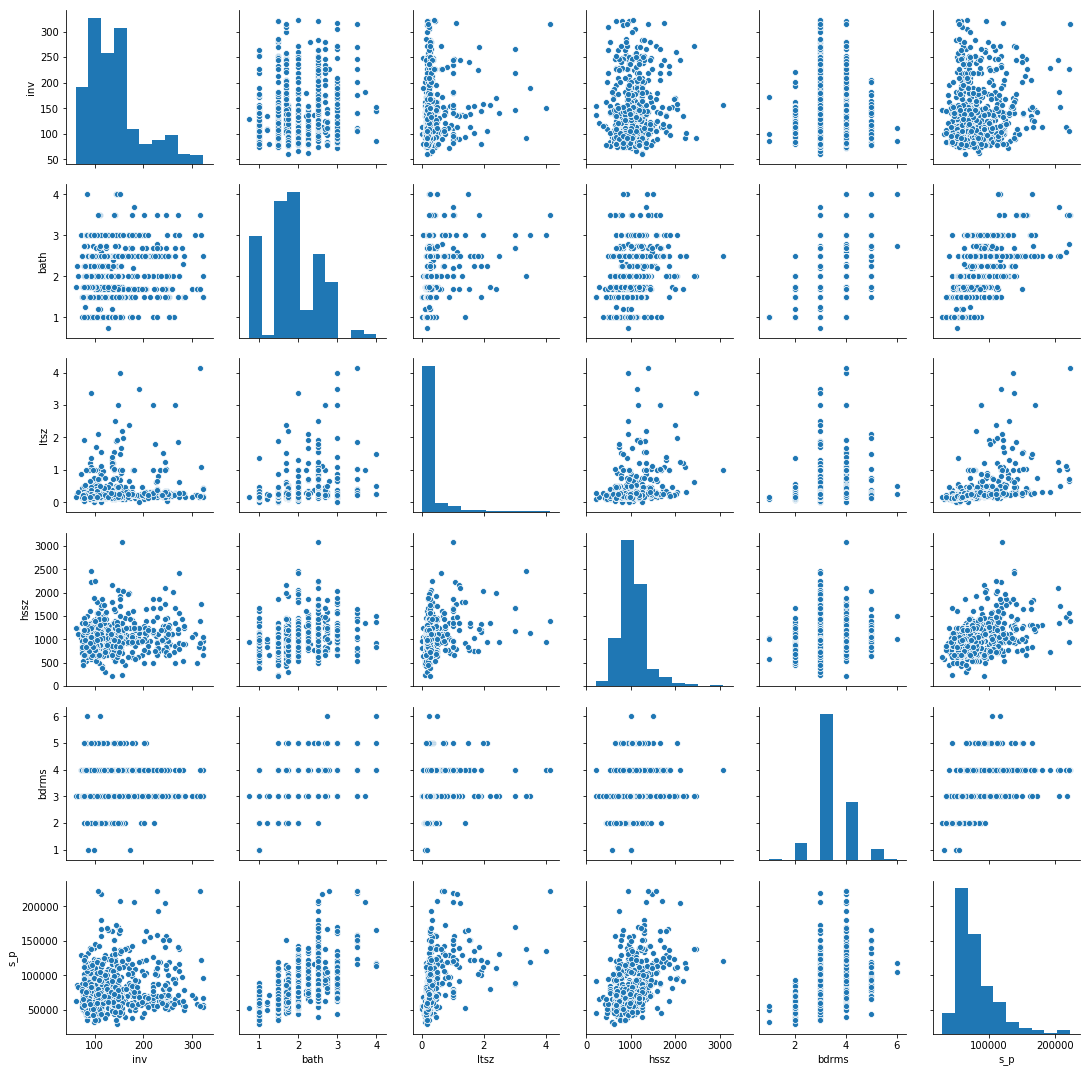

In [481]:
sns.pairplot(data_cat_months[['inv', 'bath', 'ltsz', 'hssz', 'bdrms', 's_p']])

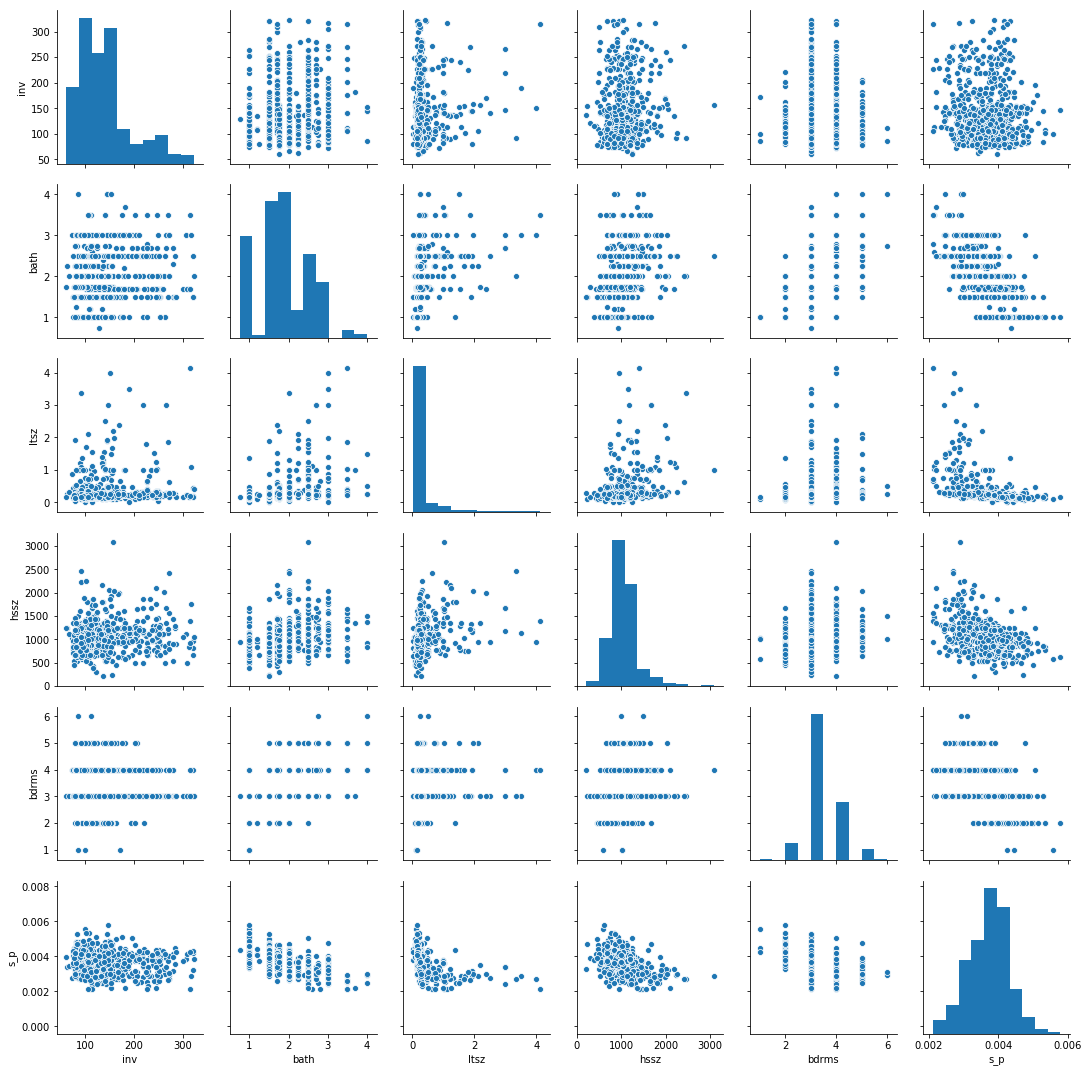

In [491]:
pairplot_transform = data_cat_months.copy()
pairplot_transform['s_p'] = 1/np.sqrt(pairplot_transform['s_p'])
sns.pairplot(pairplot_transform[['inv', 'bath', 'ltsz', 'hssz', 'bdrms', 's_p']])

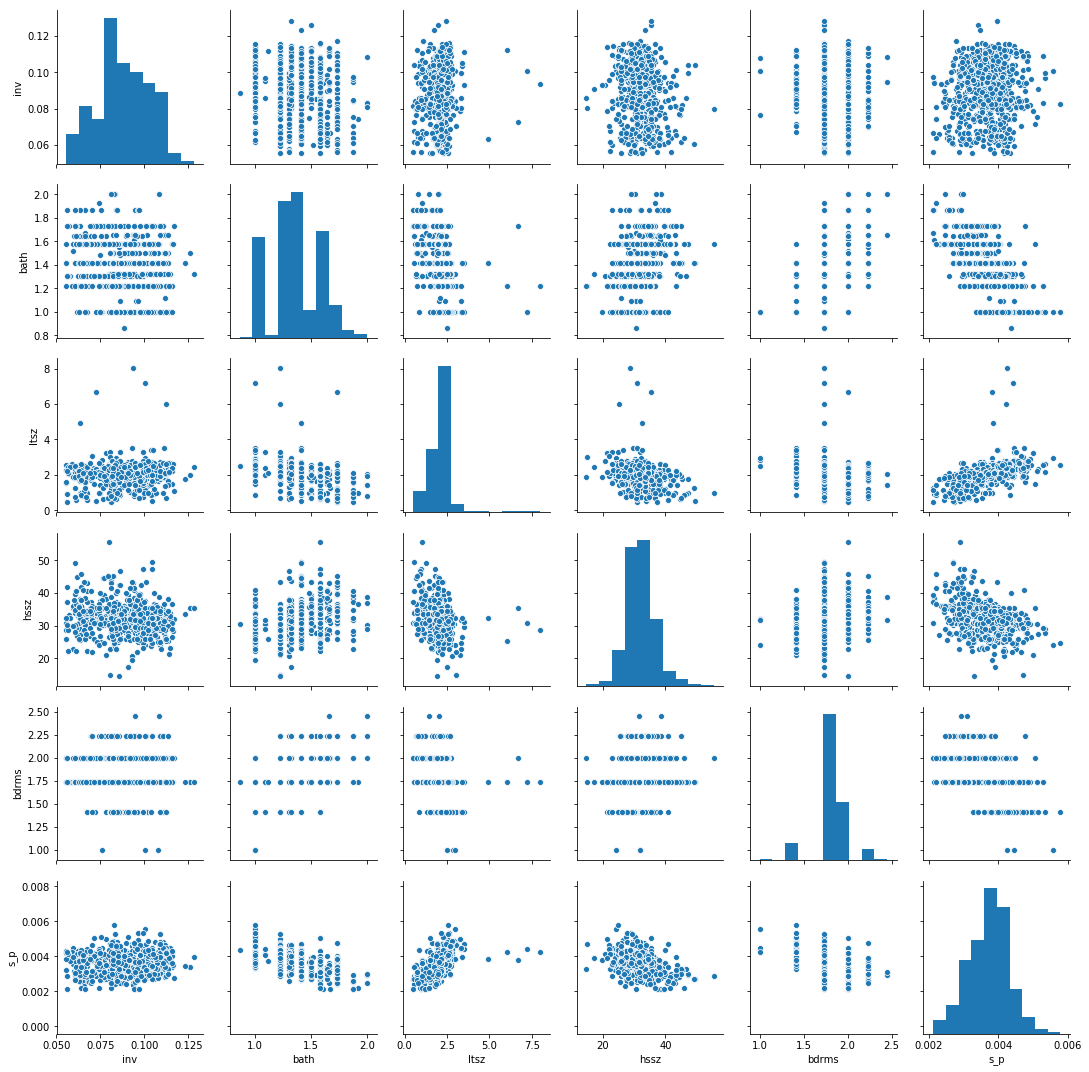

In [483]:
sns.pairplot(transformed[['inv', 'bath', 'ltsz', 'hssz', 'bdrms', 's_p']])

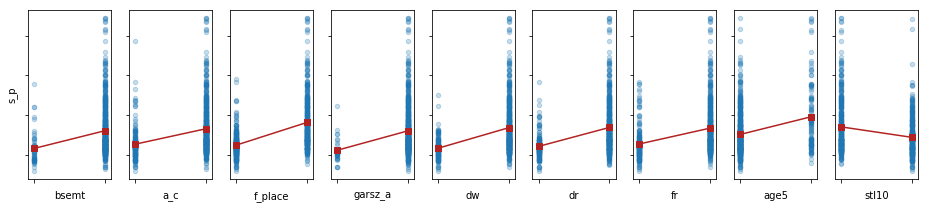

In [501]:
fig, axes = plt.subplots(ncols = len(dummy), figsize = (13, 3))#nrows = len(continuous), 
for i, d in enumerate(dummy) :
    if i == 0 :
        mean_0 = data_cat_months[data_cat_months[d] == 0][continuous[0]].mean()
        mean_1 = data_cat_months[data_cat_months[d] == 1][continuous[0]].mean()
        data_cat_months.plot.scatter(x = d, y = continuous[0], ax = axes[i], alpha = 0.25)
        axes[i].plot([0, 1], [mean_0, mean_1], c = 'firebrick', marker = 's')
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
    else :
        mean_0 = data_cat_months[data_cat_months[d] == 0][continuous[0]].mean()
        mean_1 = data_cat_months[data_cat_months[d] == 1][continuous[0]].mean()
        data_cat_months.plot.scatter(x = d, y = continuous[0], ax = axes[i], alpha = 0.25)
        axes[i].plot([0, 1], [mean_0, mean_1], c = 'firebrick', marker = 's')
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_ylabel('')
# for i, d in enumerate(dummy) :
#     data_cat_months.plot.scatter(x = d, y = continuous[1], ax = axes[0,i], alpha = 0.25)
#     axes[0,i].set_xticklabels([])
#     axes[0,i].set_yticklabels([])
# for i, d in enumerate(dummy) :
#     data_cat_months.plot.scatter(x = d, y = continuous[2], ax = axes[1,i], alpha = 0.25)
#     axes[1,i].set_xticklabels([])
#     axes[1,i].set_yticklabels([])
# for i, d in enumerate(dummy) :
#     data_cat_months.plot.scatter(x = d, y = continuous[3], ax = axes[2,i], alpha = 0.25)
#     axes[2,i].set_xticklabels([])
#     axes[2,i].set_yticklabels([])
# for i, d in enumerate(dummy) :
#     data_cat_months.plot.scatter(x = d, y = continuous[4], ax = axes[3,i], alpha = 0.25)
#     axes[3,i].set_xticklabels([])
#     axes[3,i].set_yticklabels([])
# for i, d in enumerate(dummy) :
#     data_cat_months.plot.scatter(x = d, y = continuous[5], ax = axes[4,i], alpha = 0.25)
#     axes[4,i].set_xticklabels([])
#     axes[4,i].set_yticklabels([])
# for i, d in enumerate(dummy) :
#     if i == 0 :
#         data_cat_months.plot.scatter(x = d, y = continuous[0], ax = axes[5,i], alpha = 0.25)
#         axes[5,i].set_xticklabels([])
#         axes[5,i].set_yticklabels([])
#     else :
#         data_cat_months.plot.scatter(x = d, y = continuous[0], ax = axes[5,i], alpha = 0.25)
#         axes[5,i].set_xticklabels([])
#         axes[5,i].set_yticklabels([])
#         axes[5,i].set_ylabel('')
plt.tight_layout()

bsemt two sample test:  Ttest_indResult(statistic=7.619122521498602, pvalue=7.577896195458205e-14)
a_c two sample test:  Ttest_indResult(statistic=9.735833788933341, pvalue=3.414662290627964e-21)
f_place two sample test:  Ttest_indResult(statistic=17.293152097121336, pvalue=8.762348419719634e-57)
garsz_a two sample test:  Ttest_indResult(statistic=6.461300160778497, pvalue=1.8492705027509922e-10)
dw two sample test:  Ttest_indResult(statistic=12.937494110738749, pvalue=9.329711258913338e-35)
dr two sample test:  Ttest_indResult(statistic=12.06468219436343, pvalue=8.454828741897466e-31)
fr two sample test:  Ttest_indResult(statistic=10.796767047036424, pvalue=2.186019769649755e-25)
age5 two sample test:  Ttest_indResult(statistic=6.368685614123378, pvalue=3.29227408370037e-10)
stl10 two sample test:  Ttest_indResult(statistic=-6.59248677845445, pvalue=8.070596222668744e-11)


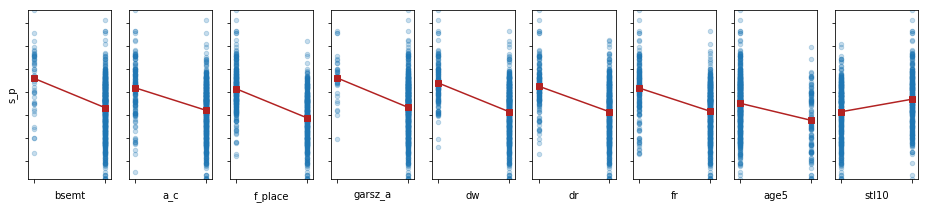

In [505]:
fig, axes = plt.subplots(ncols = len(dummy), figsize = (13, 3))#nrows = len(continuous), 
for i, d in enumerate(dummy) :
    if i == 0 :
        mean_0 = pairplot_transform[pairplot_transform[d] == 0][continuous[0]].mean()
        mean_1 = pairplot_transform[pairplot_transform[d] == 1][continuous[0]].mean()
        pairplot_transform.plot.scatter(x = d, y = continuous[0], ax = axes[i], alpha = 0.25)
        axes[i].plot([0, 1], [mean_0, mean_1], c = 'firebrick', marker = 's')
        axes[i].set_ylim(pairplot_transform[continuous[0]].min(), pairplot_transform[continuous[0]].max())
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        print ('{} two sample test: '.format(d), stats.ttest_ind(pairplot_transform[pairplot_transform[d] == 0][continuous[0]].values, pairplot_transform[pairplot_transform[d] == 1][continuous[0]].values))
    else :
        mean_0 = pairplot_transform[pairplot_transform[d] == 0][continuous[0]].mean()
        mean_1 = pairplot_transform[pairplot_transform[d] == 1][continuous[0]].mean()
        pairplot_transform.plot.scatter(x = d, y = continuous[0], ax = axes[i], alpha = 0.25)
        axes[i].plot([0, 1], [mean_0, mean_1], c = 'firebrick', marker = 's')
        axes[i].set_ylim(pairplot_transform[continuous[0]].min(), pairplot_transform[continuous[0]].max())
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_ylabel('')
        print ('{} two sample test: '.format(d), stats.ttest_ind(pairplot_transform[pairplot_transform[d] == 0][continuous[0]].values, pairplot_transform[pairplot_transform[d] == 1][continuous[0]].values))
plt.tight_layout()

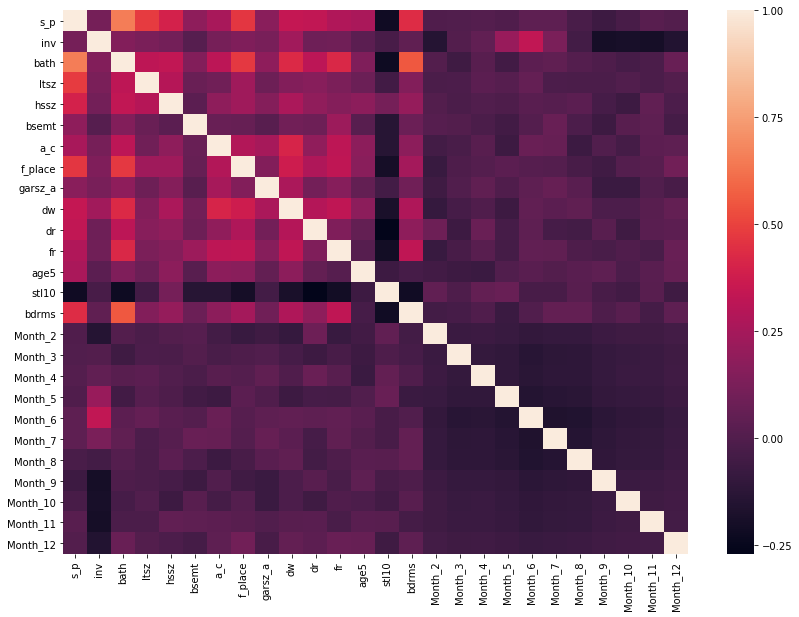

In [334]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(data_cat_months.corr(), ax = ax)
plt.show()

In [523]:
(data_cat_months[data_cat_months.columns[~data_cat_months.columns.str.contains('Month')]].corr())# > 0.45)#.sum()

,s_p,inv,bath,ltsz,hssz,bsemt,a_c,f_place,garsz_a,dw,dr,fr,age5,stl10,bdrms
s_p,1.000000,0.107805,0.653800,0.481031,0.399505,0.181808,0.257485,0.468663,0.170186,0.342288,0.334432,0.281472,0.263449,-0.219252,0.434576
inv,0.107805,1.000000,0.151368,0.126770,0.102505,0.015038,0.113066,0.139366,0.121079,0.240043,0.089502,0.096588,0.030354,-0.030101,0.043802
bath,0.653800,0.151368,1.000000,0.325116,0.332965,0.151325,0.318973,0.472493,0.184510,0.428608,0.317291,0.419927,0.139764,-0.221800,0.558119
ltsz,0.481031,0.126770,0.325116,1.000000,0.297174,0.075884,0.092179,0.231822,0.083011,0.147180,0.164497,0.126985,0.077348,-0.048632,0.147737
hssz,0.399505,0.102505,0.332965,0.297174,1.000000,0.028840,0.184494,0.235475,0.153827,0.267032,0.187729,0.154193,0.176662,0.110414,0.205536
bsemt,0.181808,0.015038,0.151325,0.075884,0.028840,1.000000,0.071467,0.063899,0.019372,0.099402,0.085330,0.221120,0.019519,-0.139128,0.080625
a_c,0.257485,0.113066,0.318973,0.092179,0.184494,0.071467,1.000000,0.287220,0.252924,0.408567,0.189308,0.323233,0.179856,-0.139109,0.177882
f_place,0.468663,0.139366,0.472493,0.231822,0.235475,0.063899,0.287220,1.000000,0.147959,0.371006,0.276291,0.329704,0.170079,-0.200454,0.246437
garsz_a,0.170186,0.121079,0.184510,0.083011,0.153827,0.019372,0.252924,0.147959,1.000000,0.270037,0.103275,0.159748,0.056493,-0.044818,0.096071
dw,0.342288,0.240043,0.428608,0.147180,0.267032,0.099402,0.408567,0.371006,0.270037,1.000000,0.293280,0.325865,0.178930,-0.182138,0.277545


In [516]:
pairplot_transform[pairplot_transform.columns[~pairplot_transform.columns.str.contains('Month')]].corr()

,s_p,inv,bath,ltsz,hssz,bsemt,a_c,f_place,garsz_a,dw,dr,fr,age5,stl10,bdrms
s_p,1.000000,-0.085698,-0.686897,-0.429487,-0.413773,-0.265901,-0.332417,-0.530641,-0.227767,-0.424151,-0.400258,-0.364048,-0.224668,0.232144,-0.487466
inv,-0.085698,1.000000,0.151368,0.126770,0.102505,0.015038,0.113066,0.139366,0.121079,0.240043,0.089502,0.096588,0.030354,-0.030101,0.043802
bath,-0.686897,0.151368,1.000000,0.325116,0.332965,0.151325,0.318973,0.472493,0.184510,0.428608,0.317291,0.419927,0.139764,-0.221800,0.558119
ltsz,-0.429487,0.126770,0.325116,1.000000,0.297174,0.075884,0.092179,0.231822,0.083011,0.147180,0.164497,0.126985,0.077348,-0.048632,0.147737
hssz,-0.413773,0.102505,0.332965,0.297174,1.000000,0.028840,0.184494,0.235475,0.153827,0.267032,0.187729,0.154193,0.176662,0.110414,0.205536
bsemt,-0.265901,0.015038,0.151325,0.075884,0.028840,1.000000,0.071467,0.063899,0.019372,0.099402,0.085330,0.221120,0.019519,-0.139128,0.080625
a_c,-0.332417,0.113066,0.318973,0.092179,0.184494,0.071467,1.000000,0.287220,0.252924,0.408567,0.189308,0.323233,0.179856,-0.139109,0.177882
f_place,-0.530641,0.139366,0.472493,0.231822,0.235475,0.063899,0.287220,1.000000,0.147959,0.371006,0.276291,0.329704,0.170079,-0.200454,0.246437
garsz_a,-0.227767,0.121079,0.184510,0.083011,0.153827,0.019372,0.252924,0.147959,1.000000,0.270037,0.103275,0.159748,0.056493,-0.044818,0.096071
dw,-0.424151,0.240043,0.428608,0.147180,0.267032,0.099402,0.408567,0.371006,0.270037,1.000000,0.293280,0.325865,0.178930,-0.182138,0.277545


In [337]:
allfeatures = list(data_cat_months.columns)
allfeatures.remove('s_p')

In [338]:
lm_0 = sm.OLS(1/np.sqrt(data_cat_months['s_p']), sm.add_constant(data_cat_months[allfeatures])).fit()
get_VIFs(lm_0, allfeatures)

inv: 1.6068458989902934
bath: 2.1775781615761187
ltsz: 1.199947236654511
hssz: 1.3271494031997806
bsemt: 1.090783261523181
a_c: 1.3572259112900598
f_place: 1.4715428123786023
garsz_a: 1.139733852423704
dw: 1.6093861875305742
dr: 1.2873325237323179
fr: 1.4159070951253352
age5: 1.1309279935135166
stl10: 1.2489557212914957
bdrms: 1.560776329079346
Month_2: 2.327678944679871
Month_3: 3.0716827395795323
Month_4: 3.0667382461936215
Month_5: 3.676397080935712
Month_6: 4.733034138495779
Month_7: 3.9906280883901313
Month_8: 3.7516426108257708
Month_9: 2.8595569230739617
Month_10: 2.4469310298524944
Month_11: 2.3702321599081904
Month_12: 1.8611492130440688


/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [339]:
lm_0_trans = sm.OLS(transformed['s_p'], sm.add_constant(transformed[allfeatures])).fit()

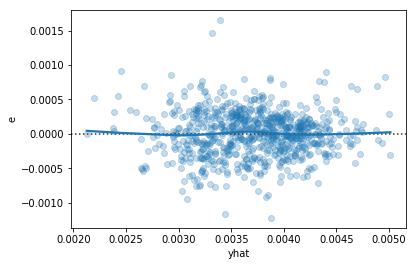

In [340]:
e, yhat = resid_plot(lm_0)

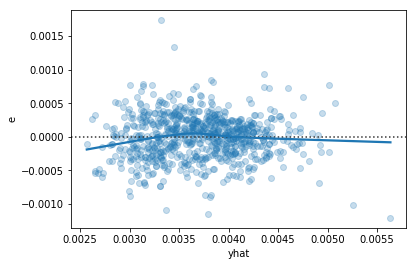

In [341]:
e_trans, yhat_trans = resid_plot(lm_0_trans)

In [342]:
_, pval, __, ___ = bp_test = het_breuschpagan(lm_0.resid, lm_0.model.exog)
pval

0.0007455825242177347

In [343]:
stats.shapiro(lm_0.resid)

(0.9889233112335205, 1.565342790854629e-05)

In [344]:
lm_step0, coefs_step0, se_step0, dropped_step0 = stepwise_by_pval(data_cat_months, 's_p')

In [345]:
lm_step0_trans, coefs_step0_trans, se_step0_trans, dropped_step0_trans = stepwise_by_pval(transformed, 's_p')

In [346]:
def check_interaction(data, y_col, x_check_col, dummies) :
    y = data[y_col]
    x_check = data[x_check_col].values
    lm_base = sm.OLS(y, sm.add_constant(x_check)).fit()
    if lm_base.pvalues.loc['x1'] > 0.05 :
        return 'nothing to see here'
    impt_dummies = list()
    impt_interactions = list()
    for d in dummies :
        d_data = data[d].values
        int_term = d_data*x_check
        data_check = np.column_stack((x_check, d_data, int_term))
        lm_check = sm.OLS(y, sm.add_constant(data_check)).fit()
        if lm_check.pvalues.loc['x2'] < 0.05 :
            impt_dummies.append(d)
        if lm_check.pvalues.loc['x3'] < 0.05 :
            impt_interactions.append(d)
    return impt_dummies, impt_interactions

In [347]:
dums, inters = check_interaction(data_cat_months, 's_p', 'bath', dummy)
print (dums)
print (inters)

['dw', 'age5']
['f_place', 'dw', 'dr', 'age5']


In [348]:
# lm = smf.ols('s_p ~ hssz', data = data).fit()
lm = smf.ols('s_p ~ hssz + hssz*bsemt', data = data_cat_months).fit()
lm.pvalues

Intercept     0.072278
hssz          0.000557
bsemt         0.138871
hssz:bsemt    0.804223
dtype: float64

In [349]:
s_p = data_cat_months['s_p'].values
hssz = data_cat_months['hssz'].values
bsemt = data_cat_months['bsemt'].values
hssz_bsemt = hssz * bsemt
int_term_hsszbsemt = np.column_stack((hssz, bsemt, hssz_bsemt))

In [350]:
lm_check = sm.OLS(s_p, sm.add_constant(int_term_hsszbsemt)).fit()
lm_check.pvalues

array([7.22783167e-02, 5.56990360e-04, 1.38870647e-01, 8.04222882e-01])

In [358]:
months = pd.get_dummies(data['month'], prefix = 'month')
data_with_months = pd.concat([data, months], axis = 1)

In [378]:
x_test = 'inv'
pvals_x_test = list()
pvals_month = list()
pvals_interaction = list()
for m in months :
    lm_month_test = smf.ols('s_p ~ {} + {}*{}'.format(x_test, x_test, m), data = data_with_months).fit()
    pvals_x_test.append(lm_month_test.pvalues[1])
    pvals_month.append(lm_month_test.pvalues[2])
    pvals_interaction.append(lm_month_test.pvalues[3])

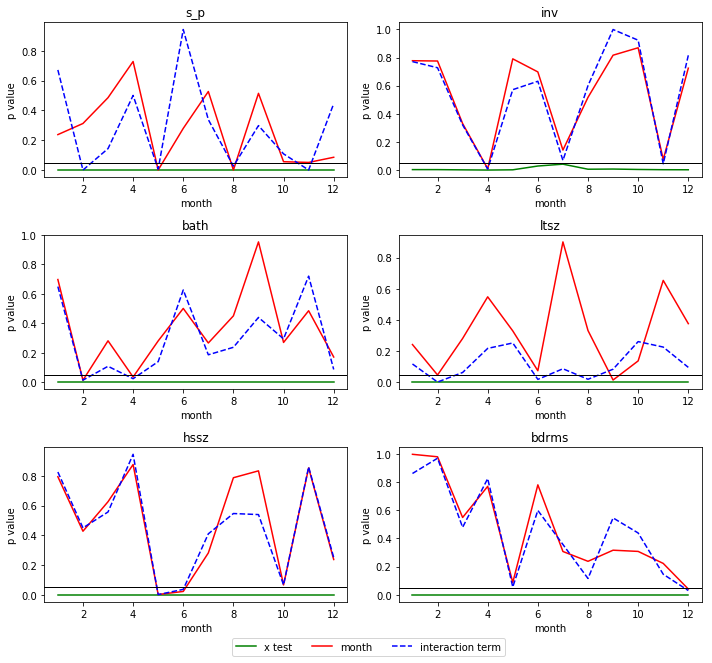

In [411]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 9))
axes = axes.ravel()
for i, c in enumerate(continuous) :
    x_test = c
    pvals_x_test = list()
    pvals_month = list()
    pvals_interaction = list()
    for m in months :
        lm_month_test = smf.ols('s_p ~ {} + {}*{}'.format(x_test, x_test, m), data = data_with_months).fit()
        pvals_x_test.append(lm_month_test.pvalues[1])
        pvals_month.append(lm_month_test.pvalues[2])
        pvals_interaction.append(lm_month_test.pvalues[3])
    axes[i].plot(np.arange(1, 13), pvals_x_test, c = 'green', label = 'x test')
    axes[i].plot(np.arange(1, 13), pvals_month, c = 'red', label = 'month')
    axes[i].plot(np.arange(1, 13), pvals_interaction, c = 'blue', ls = '--', label = 'interaction term')
    axes[i].axhline(0.05, c = 'k', lw = 1)
    axes[i].set_xlabel('month')
    axes[i].set_ylabel('p value')
    axes[i].set_title(x_test)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.2), ncol=3)
plt.show()

In [413]:
month_drop1st = pd.get_dummies(data['month'], drop_first = True, prefix = 'month')
y = data['s_p'].values
X = sm.add_constant(month_drop1st.values)
lm_month_price = sm.OLS(y, X).fit()
lm_month_price.summary()
#NO MONTHS SIGNIFICANT ON THEIR OWN (SEE F STAT)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6176
Date:                Thu, 02 May 2019   Prob (F-statistic):              0.815
Time:                        11:03:07   Log-Likelihood:                -8967.0
No. Observations:                 765   AIC:                         1.796e+04
Df Residuals:                     753   BIC:                         1.801e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.736e+04   5579.797     13.864      0.000    6.64e+04    8.83e+04
x1          1116.0379   7328.464      0.152      0.879   -1.33e+04    1.55e+04
x2          2223.9258   6694.347      0.332      0.740   -1.09e+04    1.54e+04
x3          3092.9504   6726.202      0.460      0.646   -1.01e+04    1.63e+04
x4          1433.5453   6502.378      0.220      0.826   -1.13e+04    1.42e+04
x5          4915.2976   6222.656      0.790      0.430   -7300.519    1.71e+04
x6          5277.0053   6351.952      0.831      0.406   -7192.636    1.77e+04
x7            66.4283   6390.824      0.010      0.992   -1.25e+04    1.26e+04
x8         -4540.6787   6795.756     -0.668      0.504   -1.79e+04    8800.202
x9         -1801.3186   7124.758     -0.253      0.800   -1.58e+04    1.22e+04
x10         4286.1612   7220.220      0.594      0.553   -9887.993    1.85e+04
x11         2724.7918   8115.459      0.336      0.737   -1.32e+04    1.87e+04
==============================================================================
Omnibus:                      282.569   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              978.275
Skew:                           1.773   Prob(JB):                    3.72e-213
Kurtosis:                       7.256   Cond. No.                         19.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [412]:
X_inv = np.column_stack((data['inv'].values, month_drop1st.values))
X_inv = sm.add_constant(X_inv)
lm_month_price_inv = sm.OLS(y, X_inv).fit()
lm_month_price_inv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.101
Date:                Thu, 02 May 2019   Prob (F-statistic):              0.356
Time:                        11:02:54   Log-Likelihood:                -8963.8
No. Observations:                 765   AIC:                         1.795e+04
Df Residuals:                     752   BIC:                         1.801e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.061e+04   6170.518     11.442      0.000    5.85e+04    8.27e+04
x1            62.8348     24.906      2.523      0.012      13.942     111.728
x2          1076.6579   7302.512      0.147      0.883   -1.33e+04    1.54e+04
x3           135.7043   6721.782      0.020      0.984   -1.31e+04    1.33e+04
x4           473.2219   6782.327      0.070      0.944   -1.28e+04    1.38e+04
x5         -2646.5942   6678.120     -0.396      0.692   -1.58e+04    1.05e+04
x6           310.5898   6463.648      0.048      0.962   -1.24e+04     1.3e+04
x7          2153.1761   6449.417      0.334      0.739   -1.05e+04    1.48e+04
x8         -1579.6466   6401.514     -0.247      0.805   -1.41e+04     1.1e+04
x9         -4357.5190   6772.064     -0.643      0.520   -1.77e+04    8936.881
x10        -1370.1893   7101.568     -0.193      0.847   -1.53e+04    1.26e+04
x11         4898.8378   7198.732      0.681      0.496   -9233.164     1.9e+04
x12         3345.0558   8090.438      0.413      0.679   -1.25e+04    1.92e+04
==============================================================================
Omnibus:                      270.407   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.039
Skew:                           1.713   Prob(JB):                    1.46e-193
Kurtosis:                       7.016   Cond. No.                     2.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [414]:
inv_int = data['inv'].values
X_inv_int = np.column_stack((inv_int, month_drop1st.values))
for m in month_drop1st :
    add = inv_int*month_drop1st[m].values
    X_inv_int = np.column_stack((X_inv_int, add))
X_inv_int = sm.add_constant(X_inv_int)
lm_month_price_inv = sm.OLS(y, X_inv_int).fit()
lm_month_price_inv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.241
Date:                Thu, 02 May 2019   Prob (F-statistic):              0.201
Time:                        11:05:18   Log-Likelihood:                -8956.0
No. Observations:                 765   AIC:                         1.796e+04
Df Residuals:                     741   BIC:                         1.807e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.346e+04   2.57e+04      2.469      0.014     1.3e+04    1.14e+05
x1           129.2989    233.549      0.554      0.580    -329.199     587.796
x2           893.0529   3.37e+04      0.026      0.979   -6.53e+04    6.71e+04
x3          2.078e+04   2.94e+04      0.707      0.479   -3.69e+04    7.84e+04
x4          3.766e+04   2.84e+04      1.324      0.186   -1.82e+04    9.35e+04
x5          9340.3304   2.78e+04      0.336      0.737   -4.52e+04    6.38e+04
x6          4498.0332   2.71e+04      0.166      0.868   -4.87e+04    5.77e+04
x7         -5668.9883   2.74e+04     -0.207      0.836   -5.95e+04    4.82e+04
x8           192.8760   2.82e+04      0.007      0.995   -5.51e+04    5.55e+04
x9          3467.1078    3.3e+04      0.105      0.916   -6.13e+04    6.83e+04
x10         4058.4121   3.32e+04      0.122      0.903   -6.11e+04    6.92e+04
x11        -4.168e+04   3.74e+04     -1.115      0.265   -1.15e+05    3.17e+04
x12          1.69e+04   3.83e+04      0.441      0.659   -5.83e+04    9.21e+04
x13            1.3134    305.681      0.004      0.997    -598.791     601.418
x14         -162.4462    253.143     -0.642      0.521    -659.410     334.517
x15         -267.8885    246.143     -1.088      0.277    -751.108     215.331
x16          -94.5729    240.596     -0.393      0.694    -566.904     377.758
x17          -50.1193    237.888     -0.211      0.833    -517.134     416.896
x18           28.7465    240.657      0.119      0.905    -443.704     501.197
x19          -26.2911    247.790     -0.106      0.916    -512.745     460.163
x20          -72.9996    304.085     -0.240      0.810    -669.971     523.972
x21          -49.4355    310.110     -0.159      0.873    -658.235     559.363
x22          483.3840    359.897      1.343      0.180    -223.154    1189.922
x23         -132.2306    368.477     -0.359      0.720    -855.613     591.152
==============================================================================
Omnibus:                      271.801   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.830
Skew:                           1.706   Prob(JB):                    6.72e-201
Kurtosis:                       7.156   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

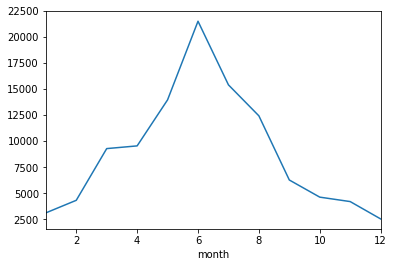

In [419]:
data.groupby('month')['inv'].sum().plot()

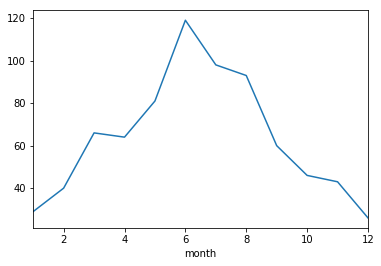

In [420]:
data.groupby('month').size().plot()

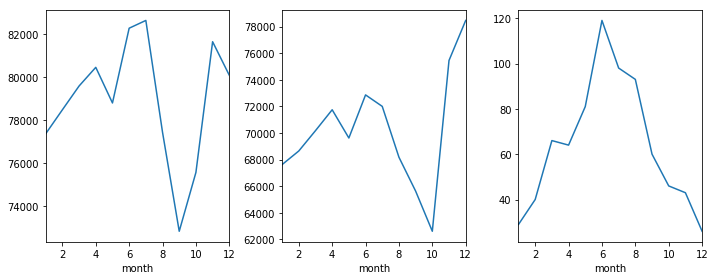

,Total sales,Median sale,Mean sale,Max sale,Min sale,Median inventory,Mean inventory
month,,,,,,,
1,29,67625.0,77356.862069,180024,50078,96.0,107.448276
2,40,68649.0,78472.900000,218620,35183,102.0,108.075000
3,66,70176.0,79580.787879,217482,29864,136.5,140.681818
4,64,71746.5,80449.812500,169845,43602,144.0,149.140625
5,81,69624.0,78790.407407,222680,41199,153.0,172.382716
6,119,72863.0,82272.159664,203975,39260,152.0,180.731092
7,98,72000.5,82633.867347,221491,37952,138.0,157.163265
8,93,68180.0,77423.290323,165658,40209,133.0,133.645161
9,60,65632.5,72816.183333,168000,32137,99.0,104.533333


In [472]:
month_grouped = data.groupby('month').agg({'s_p':['count', 'median', 'mean', 'max', 'min'], 'inv': ['median', 'mean']})
month_grouped.columns = ['Total sales', 'Median sale', 'Mean sale', 'Max sale', 'Min sale', 'Median inventory', 'Mean inventory']
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (10, 4))
month_grouped['Mean sale'].plot(ax = ax1)
month_grouped['Median sale'].plot(ax = ax2)
month_grouped['Total sales'].plot(ax = ax3)
plt.tight_layout()
plt.show()
month_grouped

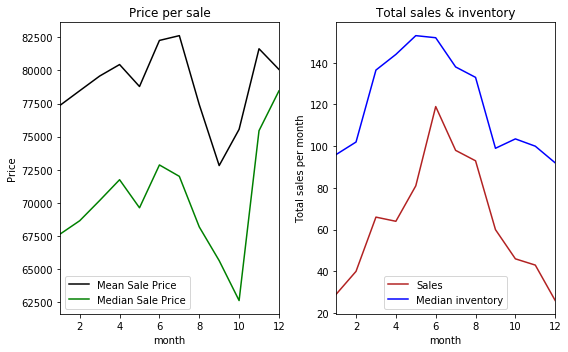

In [524]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (8, 5))
month_grouped['Mean sale'].plot(ax = ax1, label = 'Mean Sale Price', c = 'k')
month_grouped['Median sale'].plot(ax = ax1, label = 'Median Sale Price', c = 'green')
# month_grouped['Max sale'].plot(ax = ax1, label = 'Max Sale Price', c = 'k', ls = '--')
# month_grouped['Min sale'].plot(ax = ax1, label = 'Min Sale Price', c = 'k', ls = '-.')
month_grouped['Total sales'].plot(ax = ax2, c = 'firebrick', label = 'Sales')
month_grouped['Median inventory'].plot(ax = ax2, c = 'blue', label = 'Median inventory')
ax1.set_ylabel('Price')
ax2.set_ylabel('Total sales per month')
ax1.set_title('Price per sale')
ax2.set_title('Total sales & inventory')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [476]:
month_grouped.corr()

,Total sales,Median sale,Mean sale,Max sale,Min sale,Median inventory,Mean inventory
Total sales,1.000000,-0.001891,0.343969,0.378073,-0.356463,0.848768,0.862647
Median sale,-0.001891,1.000000,0.767408,-0.493228,0.551104,0.074288,0.123286
Mean sale,0.343969,0.767408,1.000000,0.024917,0.290693,0.453733,0.490851
Max sale,0.378073,-0.493228,0.024917,1.000000,-0.594146,0.453639,0.483363
Min sale,-0.356463,0.551104,0.290693,-0.594146,1.000000,-0.242202,-0.164894
Median inventory,0.848768,0.074288,0.453733,0.453639,-0.242202,1.000000,0.966708
Mean inventory,0.862647,0.123286,0.490851,0.483363,-0.164894,0.966708,1.000000


In [544]:
X = sm.add_constant(data_cat_months.loc[:, data_cat_months.columns != 's_p'])
y = data_cat_months['s_p']
# y = 1/np.sqrt(data_cat_months['s_p'])
lm_start = sm.OLS(y, X).fit()
print (np.sqrt(lm_start.scale))
lm_start.summary()

19083.668963685453


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     45.79
Date:                Sat, 04 May 2019   Prob (F-statistic):          7.00e-132
Time:                        10:23:12   Log-Likelihood:                -8612.6
No. Observations:                 765   AIC:                         1.728e+04
Df Residuals:                     739   BIC:                         1.740e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4820.6387   6839.454     -0.705      0.481   -1.82e+04    8606.436
inv          -41.1497     16.662     -2.470      0.014     -73.861      -8.439
bath        1.642e+04   1609.371     10.200      0.000    1.33e+04    1.96e+04
ltsz        1.808e+04   1770.689     10.209      0.000    1.46e+04    2.16e+04
hssz          11.7063      2.673      4.379      0.000       6.458      16.954
bsemt       8848.0108   2943.115      3.006      0.003    3070.148    1.46e+04
a_c         -308.0998   2019.510     -0.153      0.879   -4272.760    3656.560
f_place     8610.7518   1701.476      5.061      0.000    5270.448     1.2e+04
garsz_a     2737.8318   3525.323      0.777      0.438   -4183.008    9658.672
dw          -290.8338   2204.649     -0.132      0.895   -4618.956    4037.288
dr          5578.4233   1860.047      2.999      0.003    1926.817    9230.029
fr         -2793.4243   1939.254     -1.440      0.150   -6600.527    1013.678
age5        1.333e+04   2060.474      6.470      0.000    9286.885    1.74e+04
stl10      -3726.0874   1545.097     -2.412      0.016   -6759.391    -692.784
bdrms       6071.9428   1253.249      4.845      0.000    3611.589    8532.296
Month_2     3254.9989   4728.846      0.688      0.491   -6028.573    1.25e+04
Month_3     7649.2980   4306.954      1.776      0.076    -806.024    1.61e+04
Month_4     3933.3294   4363.972      0.901      0.368   -4633.930    1.25e+04
Month_5     6244.1276   4299.651      1.452      0.147   -2196.859    1.47e+04
Month_6     4682.9049   4141.643      1.131      0.259   -3447.883    1.28e+04
Month_7     4809.4989   4124.177      1.166      0.244   -3286.999    1.29e+04
Month_8      330.0516   4089.566      0.081      0.936   -7698.499    8358.603
Month_9    -3403.6565   4339.821     -0.784      0.433   -1.19e+04    5116.189
Month_10    -371.4085   4540.044     -0.082      0.935   -9284.329    8541.512
Month_11    3375.4926   4611.957      0.732      0.464   -5678.605    1.24e+04
Month_12   -6669.5030   5194.865     -1.284      0.200   -1.69e+04    3528.949
==============================================================================
Omnibus:                      222.453   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1021.531
Skew:                           1.260   Prob(JB):                    1.50e-222
Kurtosis:                       8.070   Cond. No.                     2.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [552]:
get_VIFs(lm_start, allfeatures)

inv: 1.607
bath: 2.178
ltsz: 1.200
hssz: 1.327
bsemt: 1.091
a_c: 1.357
f_place: 1.472
garsz_a: 1.140
dw: 1.609
dr: 1.287
fr: 1.416
age5: 1.131
stl10: 1.249
bdrms: 1.561
Month_2: 2.328
Month_3: 3.072
Month_4: 3.067
Month_5: 3.676
Month_6: 4.733
Month_7: 3.991
Month_8: 3.752
Month_9: 2.860
Month_10: 2.447
Month_11: 2.370
Month_12: 1.861


In [559]:
X = sm.add_constant(data_cat_months[allfeatures[:-11]])
y = data_cat_months['s_p']
y_trans = 1/np.sqrt(data_cat_months['s_p'])
lm_start_nomonths = sm.OLS(y, X).fit()
lm_start_nomonths_trans = sm.OLS(y_trans, X).fit()
print (np.sqrt(lm_start_nomonths.scale))
lm_start_nomonths.summary()

19205.69175279179


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     79.27
Date:                Sat, 04 May 2019   Prob (F-statistic):          2.33e-137
Time:                        16:39:46   Log-Likelihood:                -8623.1
No. Observations:                 765   AIC:                         1.728e+04
Df Residuals:                     750   BIC:                         1.735e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6549.1071   5777.780     -1.133      0.257   -1.79e+04    4793.438
inv          -13.3466     13.753     -0.970      0.332     -40.346      13.653
bath        1.617e+04   1608.593     10.052      0.000     1.3e+04    1.93e+04
ltsz        1.801e+04   1777.942     10.127      0.000    1.45e+04    2.15e+04
hssz          12.2349      2.679      4.566      0.000       6.975      17.495
bsemt       9904.1837   2936.186      3.373      0.001    4140.064    1.57e+04
a_c            7.6708   2016.846      0.004      0.997   -3951.664    3967.005
f_place     8740.1754   1694.148      5.159      0.000    5414.339    1.21e+04
garsz_a     3973.6861   3519.506      1.129      0.259   -2935.568    1.09e+04
dw         -1565.4176   2183.108     -0.717      0.474   -5851.147    2720.312
dr          5471.2583   1837.409      2.978      0.003    1864.181    9078.336
fr         -3062.1462   1944.438     -1.575      0.116   -6879.334     755.042
age5        1.249e+04   2056.104      6.075      0.000    8453.525    1.65e+04
stl10      -3460.3499   1542.345     -2.244      0.025   -6488.178    -432.522
bdrms       5907.3218   1253.244      4.714      0.000    3447.037    8367.606
==============================================================================
Omnibus:                      223.918   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1057.835
Skew:                           1.259   Prob(JB):                    1.97e-230
Kurtosis:                       8.181   Cond. No.                     9.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [556]:
get_VIFs(lm_start_nomonths, allfeatures[:-11])

inv: 1.081
bath: 2.148
ltsz: 1.194
hssz: 1.316
bsemt: 1.072
a_c: 1.337
f_place: 1.440
garsz_a: 1.122
dw: 1.558
dr: 1.240
fr: 1.405
age5: 1.112
stl10: 1.229
bdrms: 1.541


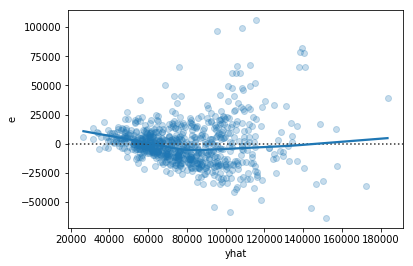

In [557]:
e, yhat = resid_plot(lm_start)

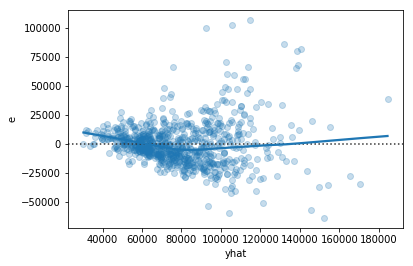

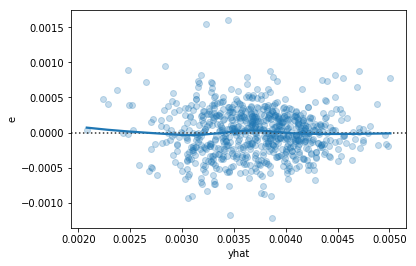

In [563]:
e, yhat = resid_plot(lm_start_nomonths)
e_trans, yhat_trans = resid_plot(lm_start_nomonths_trans)

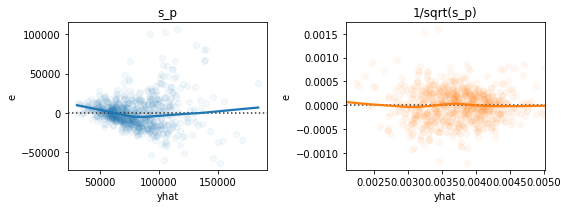

In [583]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (8, 3))
sns.residplot(yhat, e, ax = ax1, lowess = True, scatter_kws = {'alpha': 0.05})
sns.residplot(yhat_trans, e_trans, ax = ax2, lowess = True, scatter_kws = {'alpha': 0.05})
ax2.set_xlim(yhat_trans.min(), yhat_trans.max())
ax1.set_title('s_p')
ax2.set_title('1/sqrt(s_p)')
ax1.set_xlabel('yhat')
ax2.set_xlabel('yhat')
ax1.set_ylabel('e')
ax2.set_ylabel('e')
plt.tight_layout()
plt.show()

In [588]:
stats.shapiro(e)

(0.9176301956176758, 5.565997529232168e-20)

In [601]:
tstat, pval, _, __ = het_breuschpagan(lm_start_nomonths.resid, lm_start_nomonths.model.exog)
print ('tstat:', tstat)
print ('pval:', pval)

tstat: 121.81424681051473
pval: 2.7749626713977196e-19


In [604]:
stats.shapiro(e_trans)

(0.9906355738639832, 8.753823203733191e-05)

In [602]:
tstat, pval, _, __ = het_breuschpagan(lm_start_nomonths_trans.resid, lm_start_nomonths_trans.model.exog)
print ('tstat:', tstat)
print ('pval:', pval)

tstat: 38.22823739213464
pval: 0.00047946836179042345


In [664]:
lm1, lm1_coefs, lm1_se, lm1_dropped = stepwise_by_pval(data_cat_months[allfeatures[:-11]], transformed['s_p'], data_in = False)


In [665]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     136.8
Date:                Sun, 05 May 2019   Prob (F-statistic):          3.77e-171
Time:                        10:34:30   Log-Likelihood:                 5029.8
No. Observations:                 765   AIC:                        -1.004e+04
Df Residuals:                     753   BIC:                            -9980.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058   9.78e-05     59.684      0.000       0.006       0.006
inv         6.755e-07    2.4e-07      2.813      0.005    2.04e-07    1.15e-06
bath          -0.0003   2.79e-05     -9.910      0.000      -0.000      -0.000
ltsz          -0.0002   3.15e-05     -7.895      0.000      -0.000      -0.000
hssz       -2.312e-07   4.58e-08     -5.045      0.000   -3.21e-07   -1.41e-07
bsemt         -0.0004   5.09e-05     -7.475      0.000      -0.000      -0.000
a_c        -6.717e-05   3.42e-05     -1.964      0.050      -0.000   -3.48e-08
f_place       -0.0002   2.94e-05     -7.968      0.000      -0.000      -0.000
garsz_a       -0.0002   6.17e-05     -3.010      0.003      -0.000   -6.46e-05
dr            -0.0002   3.14e-05     -6.079      0.000      -0.000      -0.000
age5          -0.0002   3.61e-05     -4.529      0.000      -0.000   -9.25e-05
bdrms         -0.0001   2.18e-05     -6.770      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       21.617   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.829
Skew:                           0.117   Prob(JB):                     3.04e-10
Kurtosis:                       4.149   Cond. No.                     9.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [666]:
lm1_dropped

[('fr', 0.8459925097173554, 0.661320223119325),
 ('stl10', 0.31818271019307925, 0.6617541693090426),
 ('dw', 0.23008702610894427, 0.66175519141972)]

In [667]:
stats.shapiro(lm1.resid)

(0.990968644618988, 0.00012424198212102056)

In [668]:
tstat, pval, _, __ = het_breuschpagan(lm1.resid, lm1.model.exog)
print ('tstat:', tstat)
print ('pval:', pval)

tstat: 32.67742161662532
pval: 0.0005933451011313953


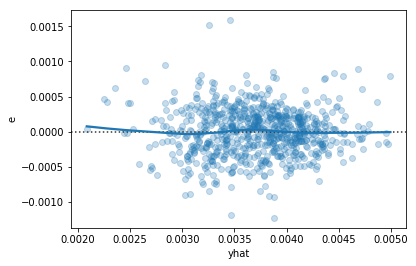

In [643]:
e_1, yhat_1 = resid_plot(lm1)

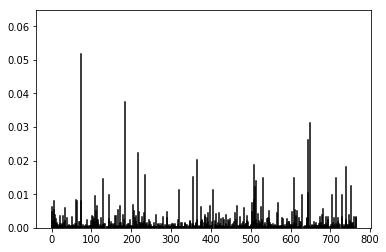

In [644]:
cooks_1 = cooks_plot(lm1)

In [684]:
for i in range(len(allfeatures[:-11])) :
    lm_check = sm.OLS(data_cat_months['s_p'], sm.add_constant(data_cat_months[allfeatures[i]])).fit()
    tstat, pval, _, __ = het_breuschpagan(lm_check.resid, lm_check.model.exog)
    print (allfeatures[i])
    print ('norm:', round(stats.shapiro(lm_check.resid)[1], 3), stats.shapiro(lm_check.resid)[1] > 0.05)
    print ('homo:', round(pval, 3), pval > 0.05)
    print ('=====')

inv
norm: 0.0 False
homo: 0.001 False
=====
bath
norm: 0.0 False
homo: 0.0 False
=====
ltsz
norm: 0.0 False
homo: 0.0 False
=====
hssz
norm: 0.0 False
homo: 0.017 False
=====
bsemt
norm: 0.0 False
homo: 0.179 True
=====
a_c
norm: 0.0 False
homo: 0.028 False
=====
f_place
norm: 0.0 False
homo: 0.0 False
=====
garsz_a
norm: 0.0 False
homo: 0.066 True
=====
dw
norm: 0.0 False
homo: 0.0 False
=====
dr
norm: 0.0 False
homo: 0.0 False
=====
fr
norm: 0.0 False
homo: 0.01 False
=====
age5
norm: 0.0 False
homo: 0.0 False
=====
stl10
norm: 0.0 False
homo: 0.001 False
=====
bdrms
norm: 0.0 False
homo: 0.0 False
=====


In [678]:
get_VIFs(lm1, list(lm1.params.index[1:]))

inv: 1.050
bath: 2.058
ltsz: 1.192
hssz: 1.227
bsemt: 1.028
a_c: 1.224
f_place: 1.380
garsz_a: 1.098
dr: 1.157
age5: 1.090
bdrms: 1.490


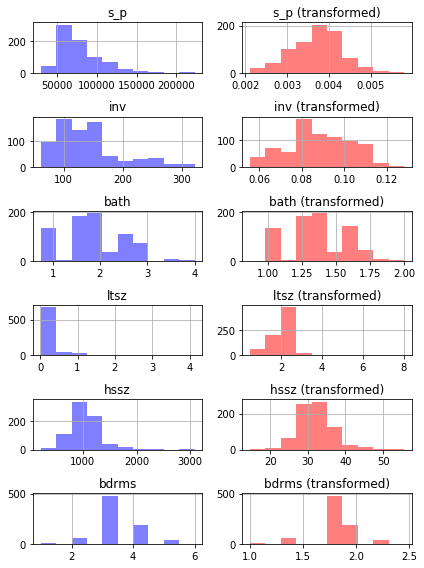

In [705]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (6, 8))
axes = axes.ravel()
for c, i in zip(range(len(continuous)), np.arange(0, 12, 2)) :
    data_cat_months[continuous[c]].hist(ax = axes[i], alpha = 0.5, color = 'blue')
    transformed[continuous[c]].hist(ax = axes[i+1], alpha = 0.5, color = 'red')
    axes[i].set_title(continuous[c])
    axes[i+1].set_title(continuous[c] + ' (transformed)')
plt.tight_layout()

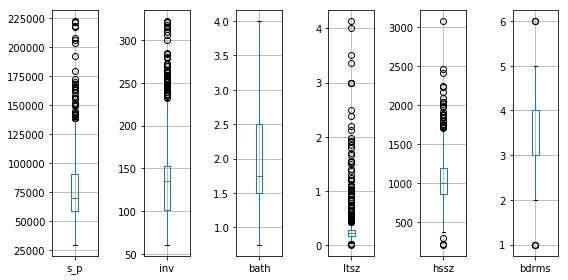

In [713]:
fig, axes = plt.subplots(ncols = 6, figsize = (8, 4))
for i in range(len(continuous)) :
    data_cat_months.boxplot(column = continuous[i], ax = axes[i])
plt.tight_layout()

In [866]:
Q1_nobed = data_cat_months[continuous[:-1]].quantile(0.25)
Q3_nobed = data_cat_months[continuous[:-1]].quantile(0.75)
IQR_nobed = Q3_nobed - Q1_nobed
low_nobed = Q1 - 0.5*IQR_nobed
high_nobed = Q3_nobed + 0.5*IQR_nobed
data_continuous_nobed = data_cat_months[continuous[:-1]].copy()
data_continuous_nobed_IQR = data_continuous_nobed[~((data_continuous_nobed < low) | (data_continuous_nobed > high)).any(axis = 1)]
data_continuous_nobed_IQR = data_cat_months.loc[data_continuous_nobed_IQR.index]


In [872]:
data_continuous_nobed_IQR['bdrms'].value_counts().sort_index()

1      1
2     21
3    286
4     76
5     18
Name: bdrms, dtype: int64

In [724]:
Q1 = data_cat_months[continuous].quantile(0.25)
Q3 = data_cat_months[continuous].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 0.5*IQR
high = Q3 + 0.5*IQR

In [727]:
data_continuous = data_cat_months[continuous].copy()

In [731]:
data_continuous_IQR = data_continuous[~((data_continuous < low) | (data_continuous > high)).any(axis = 1)]

In [873]:
data_cat_months['bdrms'].value_counts().sort_index()

1      3
2     54
3    479
4    191
5     36
6      2
Name: bdrms, dtype: int64

In [874]:
IQR_use['bdrms'].value_counts().sort_index()

3    286
4     76
Name: bdrms, dtype: int64

In [746]:
data_cat_months_IQR = data_cat_months.loc[data_continuous_IQR.index]

In [875]:
for i in range(len(continuous)) :
    lm_check = sm.OLS(1/np.sqrt(data_continuous_nobed_IQR['s_p']), sm.add_constant(data_continuous_nobed_IQR[continuous[i]])).fit()
    tstat, pval, _, __ = het_breuschpagan(lm_check.resid, lm_check.model.exog)
    print (continuous[i])
    print ('norm:', round(stats.shapiro(lm_check.resid)[1], 3), stats.shapiro(lm_check.resid)[1] > 0.05)
    print ('homo:', round(pval, 3), pval > 0.05)
    print ('=====')

s_p
norm: 0.0 False
homo: 0.954 True
=====
inv
norm: 0.044 False
homo: 0.389 True
=====
bath
norm: 0.024 False
homo: 0.602 True
=====
ltsz
norm: 0.34 True
homo: 0.535 True
=====
hssz
norm: 0.003 False
homo: 0.0 False
=====
bdrms
norm: 0.302 True
homo: 0.406 True
=====


In [876]:
lm2, lm2_coefs, lm2_se, lm2_dropped = stepwise_by_pval(data_continuous_nobed_IQR[allfeatures[:-11]], 1/np.sqrt(data_continuous_nobed_IQR['s_p']), data_in = False)


In [880]:
lm2_dropped

[('hssz', 0.9230594444880247, 0.5609865437214092),
 ('dw', 0.3209639131502259, 0.5621074537098474),
 ('fr', 0.09697909344950006, 0.5621214807936532),
 ('stl10', 0.12539769787462057, 0.5601365717835772),
 ('age5', 0.12039557700956102, 0.5586080868639969)]

In [878]:
stats.shapiro(lm2.resid)

(0.9859118461608887, 0.0006049108342267573)

In [879]:
tstat, pval, _, __ = het_breuschpagan(lm2.resid, lm2.model.exog)
print (pval)

0.43630522900407337


In [898]:
IQR_use = data_continuous_nobed_IQR.copy()

In [913]:
IQR_use['s_p'] = 1/np.sqrt(IQR_use['s_p'])

In [914]:
lm3, lm3_coefs, lm3_se, lm3_dropped = stepwise_by_pval(IQR_use, 's_p')


In [915]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     43.20
Date:                Mon, 06 May 2019   Prob (F-statistic):           3.49e-70
Time:                        00:16:06   Log-Likelihood:                 2792.1
No. Observations:                 402   AIC:                            -5554.
Df Residuals:                     387   BIC:                            -5494.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.000     42.660      0.000       0.005       0.005
inv         2.638e-06   5.16e-07      5.117      0.000    1.62e-06    3.65e-06
bath          -0.0001   2.96e-05     -4.386      0.000      -0.000   -7.17e-05
ltsz          -0.0019      0.000     -6.559      0.000      -0.002      -0.001
bsemt         -0.0003   5.06e-05     -5.138      0.000      -0.000      -0.000
a_c        -7.965e-05   3.32e-05     -2.399      0.017      -0.000   -1.44e-05
f_place       -0.0002   2.73e-05     -6.176      0.000      -0.000      -0.000
garsz_a       -0.0001   5.76e-05     -2.120      0.035      -0.000   -8.87e-06
dw         -8.112e-05   3.36e-05     -2.415      0.016      -0.000   -1.51e-05
dr            -0.0002   2.73e-05     -5.925      0.000      -0.000      -0.000
bdrms      -8.461e-05    2.3e-05     -3.671      0.000      -0.000   -3.93e-05
Month_5       -0.0001   4.24e-05     -2.505      0.013      -0.000   -2.29e-05
Month_9        0.0002   4.51e-05      3.669      0.000    7.68e-05       0.000
Month_10       0.0002   4.67e-05      3.975      0.000    9.38e-05       0.000
Month_11       0.0002   5.18e-05      3.818      0.000     9.6e-05       0.000
==============================================================================
Omnibus:                        6.447   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                8.761
Skew:                          -0.104   Prob(JB):                       0.0125
Kurtosis:                       3.693   Cond. No.                     3.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [916]:
IQR_use_monthsinter = IQR_use.copy()

In [917]:
months = ['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']

In [918]:
for m in months :
    newcol = 'Inv_' + m
    IQR_use_monthsinter[newcol] = IQR_use_monthsinter['inv']*IQR_use_monthsinter[m]

In [919]:
IQR_use_monthsinter = IQR_use_monthsinter.drop(months, axis = 1)

In [920]:
lm4, lm4_coefs, lm4_se, lm4_dropped = stepwise_by_pval(IQR_use_monthsinter, 's_p')


In [921]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     43.61
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.15e-70
Time:                        00:16:11   Log-Likelihood:                 2793.3
No. Observations:                 402   AIC:                            -5557.
Df Residuals:                     387   BIC:                            -5497.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0051      0.000     43.564      0.000       0.005       0.005
inv           2.395e-06   5.02e-07      4.771      0.000    1.41e-06    3.38e-06
bath            -0.0001   2.96e-05     -4.462      0.000      -0.000   -7.38e-05
ltsz            -0.0019      0.000     -6.572      0.000      -0.002      -0.001
bsemt           -0.0003   5.04e-05     -5.125      0.000      -0.000      -0.000
a_c          -7.477e-05   3.31e-05     -2.257      0.025      -0.000   -9.63e-06
f_place         -0.0002   2.73e-05     -6.145      0.000      -0.000      -0.000
garsz_a         -0.0001   5.74e-05     -2.244      0.025      -0.000    -1.6e-05
dw           -8.525e-05   3.36e-05     -2.539      0.011      -0.000   -1.92e-05
dr              -0.0002   2.73e-05     -6.001      0.000      -0.000      -0.000
bdrms        -8.211e-05    2.3e-05     -3.564      0.000      -0.000   -3.68e-05
Inv_Month_5  -6.565e-07   2.91e-07     -2.258      0.024   -1.23e-06   -8.49e-08
Inv_Month_9   1.686e-06   4.31e-07      3.915      0.000    8.39e-07    2.53e-06
Inv_Month_10  1.843e-06   4.34e-07      4.247      0.000     9.9e-07     2.7e-06
Inv_Month_11  1.899e-06   5.29e-07      3.589      0.000    8.59e-07    2.94e-06
==============================================================================
Omnibus:                        6.299   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                8.377
Skew:                          -0.111   Prob(JB):                       0.0152
Kurtosis:                       3.672   Cond. No.                     3.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [922]:
print (lm4_se)
print (lm4_coefs)
lm4_dropped

0.00023676091700377581
const           5.119339e-03
inv             2.395168e-06
bath           -1.318648e-04
ltsz           -1.903424e-03
bsemt          -2.583832e-04
a_c            -7.476583e-05
f_place        -1.675066e-04
garsz_a        -1.288497e-04
dw             -8.524837e-05
dr             -1.635456e-04
bdrms          -8.211010e-05
Inv_Month_5    -6.565081e-07
Inv_Month_9     1.686484e-06
Inv_Month_10    1.843427e-06
Inv_Month_11    1.898903e-06
dtype: float64


[('Inv_Month_8', 0.8081767711103935, 0.6031443641483396),
 ('hssz', 0.7456118349994723, 0.6041348983395554),
 ('Inv_Month_7', 0.698424045585884, 0.6050717687933747),
 ('Inv_Month_4', 0.47693387334054194, 0.6059571321475756),
 ('stl10', 0.2569447224535446, 0.6064684831250711),
 ('Inv_Month_2', 0.20222951220028648, 0.6061699597510546),
 ('Inv_Month_3', 0.21512926063918716, 0.6055185742634182),
 ('fr', 0.19817329797403407, 0.6049606526382063),
 ('Inv_Month_6', 0.09437058327650956, 0.604280092874224),
 ('Inv_Month_12', 0.0694088463503923, 0.6024175536602583),
 ('age5', 0.08778706617277453, 0.6000326556770454)]

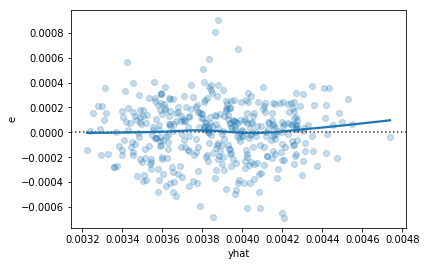

In [923]:
e4, yhat4 = resid_plot(lm4)

In [924]:
stats.shapiro(e4)

(0.9873300790786743, 0.0014224076876416802)

In [925]:
tstat, pval, _, __ = het_breuschpagan(e4, lm4.model.exog)
print (pval)

0.004252386121267694


In [927]:
(1/((IQR_use_monthsinter.iloc[0].loc[lm4.params.index] * lm4.params).sum() + lm4.params.loc['const'])) ** 2

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


69211.04208345151

In [928]:
IQR_use_hsszinter = IQR_use.copy()

In [930]:
IQR_use_hsszinter = IQR_use_hsszinter.drop(months, axis = 1)

In [932]:
hssz_inter_cols = ['bsemt', 'ltsz', 'bath', 'dr', 'fr', 'bdrms', 'garsz_a']

In [934]:
for h in hssz_inter_cols :
    newcol = 'hssz_' + h
    IQR_use_hsszinter[newcol] = IQR_use_hsszinter['inv']*IQR_use_hsszinter[h]

In [936]:
lm5, lm5_coefs, lm5_se, lm5_dropped = stepwise_by_pval(IQR_use_hsszinter, 's_p')


In [937]:
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     52.81
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.93e-66
Time:                        00:22:28   Log-Likelihood:                 2774.8
No. Observations:                 402   AIC:                            -5528.
Df Residuals:                     391   BIC:                            -5484.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.000     33.400      0.000       0.005       0.005
inv         2.984e-06   1.01e-06      2.957      0.003       1e-06    4.97e-06
ltsz          -0.0019      0.000     -6.371      0.000      -0.002      -0.001
a_c        -8.346e-05   3.35e-05     -2.490      0.013      -0.000   -1.76e-05
f_place       -0.0002   2.76e-05     -6.472      0.000      -0.000      -0.000
garsz_a       -0.0002   5.91e-05     -2.544      0.011      -0.000   -3.41e-05
dr            -0.0005      0.000     -3.846      0.000      -0.001      -0.000
bdrms         -0.0001   2.33e-05     -4.530      0.000      -0.000   -5.98e-05
hssz_bsemt -2.118e-06   4.34e-07     -4.877      0.000   -2.97e-06   -1.26e-06
hssz_bath  -1.095e-06   2.41e-07     -4.542      0.000   -1.57e-06   -6.21e-07
hssz_dr     2.704e-06   1.03e-06      2.627      0.009     6.8e-07    4.73e-06
==============================================================================
Omnibus:                        8.669   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               11.947
Skew:                           0.172   Prob(JB):                      0.00255
Kurtosis:                       3.771   Cond. No.                     7.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1060]:
lm5.params

const         0.005122
inv           0.000003
ltsz         -0.001903
a_c          -0.000083
f_place      -0.000179
garsz_a      -0.000150
dr           -0.000490
bdrms        -0.000106
hssz_bsemt   -0.000002
hssz_bath    -0.000001
hssz_dr       0.000003
dtype: float64

In [939]:
print (lm5_se)
lm5_dropped

0.00024666959440403796


[('hssz', 0.9889650944130335, 0.563543937104737),
 ('hssz_bdrms', 0.9532849597310282, 0.5646892716577603),
 ('bsemt', 0.9283585114814498, 0.5658249125810326),
 ('hssz_garsz_a', 0.7351326052409404, 0.5669493529027019),
 ('hssz_ltsz', 0.5670648005111353, 0.5679478305602557),
 ('bath', 0.45060405212622934, 0.5687017498606906),
 ('hssz_fr', 0.4014115764670788, 0.5691818837404536),
 ('dw', 0.272416597431235, 0.5695095611482471),
 ('fr', 0.0930680614550081, 0.5692788093610961),
 ('stl10', 0.10348639712284095, 0.5672476362679963),
 ('age5', 0.11177847938505898, 0.5654018257433702)]

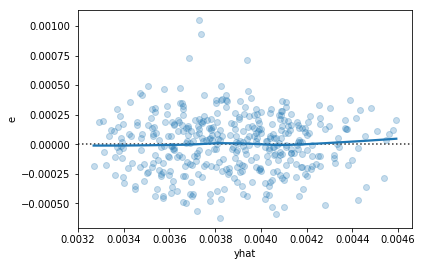

In [940]:
e5, yhat5 = resid_plot(lm5)

In [941]:
stats.shapiro(e5)

(0.9861240983009338, 0.0006861051660962403)

In [942]:
tstat, pval, _, __ = het_breuschpagan(e5, lm5.model.exog)
print (pval)

0.6542829180567424


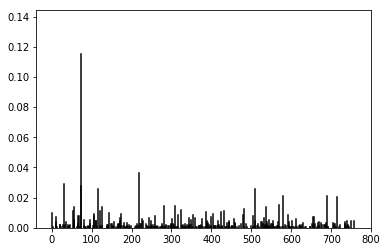

In [1063]:
cooks = cooks_plot(lm5)

In [959]:
common_cols = ['s_p', 'inv', 'bath', 'ltsz', 'hssz', 'bsemt', 'a_c', 'f_place', 'garsz_a', 'dw', 'dr', 'fr', 'age5', 'stl10', 'bdrms']


In [973]:
IQR_use_common = IQR_use_hsszinter[common_cols]

In [979]:
hsszinters = IQR_use_hsszinter.iloc[:, len(common_cols):]
monthsinters = IQR_use_monthsinter.iloc[:, len(common_cols):]

In [983]:
IQR_use_allinters = pd.concat([IQR_use_common, hsszinters, monthsinters], axis = 1)

In [1062]:
IQR_use_allinters.shape

(402, 33)

In [984]:
lm6, lm6_coefs, lm6_se, lm6_dropped = stepwise_by_pval(IQR_use_allinters, 's_p')


In [985]:
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     41.84
Date:                Mon, 06 May 2019   Prob (F-statistic):           2.33e-71
Time:                        00:43:31   Log-Likelihood:                 2797.0
No. Observations:                 402   AIC:                            -5562.
Df Residuals:                     386   BIC:                            -5498.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0049      0.000     33.077      0.000       0.005       0.005
inv           3.913e-06   9.79e-07      3.995      0.000    1.99e-06    5.84e-06
ltsz            -0.0021      0.000     -7.169      0.000      -0.003      -0.001
f_place         -0.0002    2.7e-05     -6.569      0.000      -0.000      -0.000
garsz_a         -0.0001   5.61e-05     -2.518      0.012      -0.000   -3.09e-05
dw           -9.079e-05   3.25e-05     -2.794      0.005      -0.000   -2.69e-05
dr              -0.0005      0.000     -4.271      0.000      -0.001      -0.000
age5         -7.965e-05    3.7e-05     -2.154      0.032      -0.000   -6.95e-06
bdrms        -8.966e-05   2.24e-05     -3.997      0.000      -0.000   -4.56e-05
hssz_bsemt   -1.967e-06   4.15e-07     -4.734      0.000   -2.78e-06   -1.15e-06
hssz_bath    -1.132e-06   2.34e-07     -4.837      0.000   -1.59e-06   -6.72e-07
hssz_dr        2.91e-06   9.87e-07      2.948      0.003    9.69e-07    4.85e-06
Inv_Month_9   1.946e-06   4.31e-07      4.516      0.000     1.1e-06    2.79e-06
Inv_Month_10      2e-06   4.33e-07      4.613      0.000    1.15e-06    2.85e-06
Inv_Month_11   2.09e-06   5.31e-07      3.934      0.000    1.05e-06    3.13e-06
Inv_Month_12  1.239e-06    5.6e-07      2.211      0.028    1.37e-07    2.34e-06
==============================================================================
Omnibus:                        2.853   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                3.048
Skew:                          -0.051   Prob(JB):                        0.218
Kurtosis:                       3.414   Cond. No.                     7.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [986]:
print (lm6_se)
lm6_dropped

0.00023487794239212555


[('hssz_garsz_a', 0.918627640096095, 0.6059675038445689),
 ('bsemt', 0.8691022358224314, 0.6070213261944563),
 ('hssz', 0.8214658195661149, 0.608051760323997),
 ('hssz_bdrms', 0.7989911608305604, 0.6090516554282939),
 ('Inv_Month_8', 0.731685674653066, 0.6100317084153769),
 ('Inv_Month_7', 0.5801238616221206, 0.6109516313438831),
 ('hssz_ltsz', 0.5691545870303814, 0.6116710394482907),
 ('Inv_Month_4', 0.4503002155426288, 0.6123685113554767),
 ('bath', 0.3850322213935651, 0.6128095192022305),
 ('hssz_fr', 0.3803032308568366, 0.613059111628752),
 ('Inv_Month_3', 0.244864751397791, 0.6132923722320869),
 ('Inv_Month_2', 0.2919128396371776, 0.6129295043618275),
 ('stl10', 0.2002237437081603, 0.6128138203542961),
 ('fr', 0.19100939524831095, 0.6121586012973024),
 ('Inv_Month_6', 0.08795446476304984, 0.6114336561158811),
 ('a_c', 0.0640443711627356, 0.6094844063896638),
 ('Inv_Month_5', 0.06040915273449615, 0.6070000272086385)]

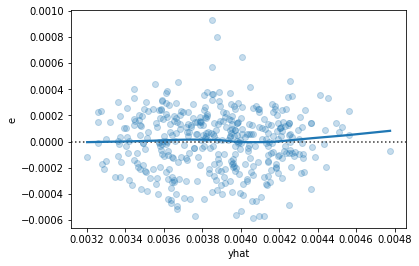

In [987]:
e6, yhat6 = resid_plot(lm6)

In [988]:
stats.shapiro(e6)

(0.9867844581604004, 0.0010198733070865273)

In [989]:
tstat, pval, _, __ = het_breuschpagan(e6, lm6.model.exog)
print (pval)

0.011873679852605751


In [993]:
all_params = set(lm6.params.index)
hssz_params = set(lm5.params.index)
month_params = set(lm4.params.index)

In [1007]:
all_params & hssz_params & month_params

{'bdrms', 'const', 'dr', 'f_place', 'garsz_a', 'inv', 'ltsz'}

In [1005]:
joint_list = list(all_params & hssz_params & month_params)
joint_list.remove('const')
X_joint = IQR_use[joint_list]
lm_7 = sm.OLS(IQR_use['s_p'], sm.add_constant(X_joint)).fit()
lm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     66.17
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.06e-56
Time:                        00:57:33   Log-Likelihood:                 2742.8
No. Observations:                 402   AIC:                            -5472.
Df Residuals:                     395   BIC:                            -5444.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.000     44.014      0.000       0.005       0.005
bdrms         -0.0001   2.26e-05     -6.533      0.000      -0.000      -0.000
garsz_a       -0.0002   6.18e-05     -3.506      0.001      -0.000   -9.52e-05
dr            -0.0002   2.96e-05     -6.575      0.000      -0.000      -0.000
ltsz          -0.0023      0.000     -7.451      0.000      -0.003      -0.002
f_place       -0.0002   2.82e-05     -8.017      0.000      -0.000      -0.000
inv         1.074e-06   5.01e-07      2.144      0.033    8.91e-08    2.06e-06
==============================================================================
Omnibus:                        5.249   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.144
Skew:                           0.222   Prob(JB):                       0.0764
Kurtosis:                       3.333   Cond. No.                     2.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

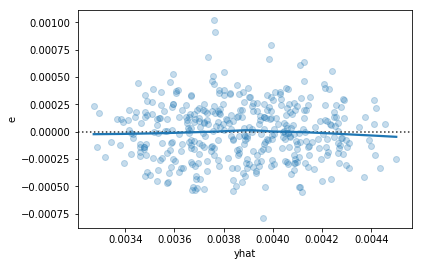

In [1009]:
e7, yhat7 = resid_plot(lm_7)

In [1010]:
stats.shapiro(e7)

(0.9923380613327026, 0.03697159141302109)

In [1012]:
tstat, pval, _, __ = het_breuschpagan(e7, lm_7.model.exog)
print (pval)

0.8940152529928463


In [1053]:
np.sqrt(lm_7.scale)

0.0002657159750217536

In [1013]:
joint_list

['bdrms', 'garsz_a', 'dr', 'ltsz', 'f_place', 'inv']

In [1015]:
lm6.params.index

Index(['const', 'inv', 'ltsz', 'f_place', 'garsz_a', 'dw', 'dr', 'age5',
       'bdrms', 'hssz_bsemt', 'hssz_bath', 'hssz_dr', 'Inv_Month_9',
       'Inv_Month_10', 'Inv_Month_11', 'Inv_Month_12'],
      dtype='object')

In [1054]:
augment_list = ['bdrms', 'garsz_a', 'dr', 'ltsz', 'f_place', 'inv', 'hssz_bsemt', 'hssz_bath', 'hssz_dr', 'Inv_Month_12', 'Inv_Month_9',
       'Inv_Month_10', 'Inv_Month_11']

In [1055]:
lm8 = sm.OLS(IQR_use_allinters['s_p'], sm.add_constant(IQR_use_allinters[augment_list])).fit()

In [1056]:
print (np.sqrt(lm8.scale))
lm8.summary()

0.00023864776688171447


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     45.68
Date:                Mon, 06 May 2019   Prob (F-statistic):           5.53e-70
Time:                        18:58:09   Log-Likelihood:                 2789.6
No. Observations:                 402   AIC:                            -5551.
Df Residuals:                     388   BIC:                            -5495.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0049      0.000     32.666      0.000       0.005       0.005
bdrms        -9.042e-05   2.28e-05     -3.972      0.000      -0.000   -4.57e-05
garsz_a         -0.0002    5.6e-05     -3.174      0.002      -0.000   -6.76e-05
dr              -0.0005      0.000     -4.343      0.000      -0.001      -0.000
ltsz            -0.0021      0.000     -7.302      0.000      -0.003      -0.002
f_place         -0.0002   2.68e-05     -7.327      0.000      -0.000      -0.000
inv           4.035e-06   9.94e-07      4.060      0.000    2.08e-06    5.99e-06
hssz_bsemt   -2.012e-06   4.22e-07     -4.768      0.000   -2.84e-06   -1.18e-06
hssz_bath    -1.277e-06   2.34e-07     -5.461      0.000   -1.74e-06   -8.18e-07
hssz_dr       2.966e-06      1e-06      2.966      0.003       1e-06    4.93e-06
Inv_Month_12  1.023e-06   5.66e-07      1.807      0.072   -9.03e-08    2.14e-06
Inv_Month_9   1.767e-06   4.35e-07      4.060      0.000    9.11e-07    2.62e-06
Inv_Month_10  1.817e-06   4.36e-07      4.165      0.000    9.59e-07    2.68e-06
Inv_Month_11  1.847e-06   5.36e-07      3.446      0.001    7.93e-07     2.9e-06
==============================================================================
Omnibus:                        3.890   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.753
Skew:                          -0.005   Prob(JB):                       0.0929
Kurtosis:                       3.533   Cond. No.                     7.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

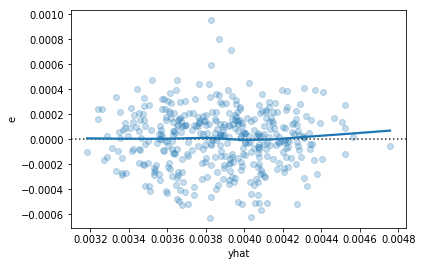

In [1057]:
e8, yhat8 = resid_plot(lm8)

In [1058]:
stats.shapiro(e8)

(0.9886966943740845, 0.003340077353641391)

In [1059]:
tstat, pval, _, __ = het_breuschpagan(e8, lm8.model.exog)
print (pval)

0.01832680744460134


In [1066]:
cooks[cooks > 0.05]

73    0.115352
Name: cooks_d, dtype: float64

In [1072]:
IQR_final = IQR_use_hsszinter.drop(73)

In [1077]:
final_features = list(lm5.params.index)
final_features.remove('const')

In [1078]:
lmf = sm.OLS(IQR_final['s_p'], sm.add_constant(IQR_final[final_features])).fit()

In [1079]:
lmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     56.00
Date:                Mon, 06 May 2019   Prob (F-statistic):           3.09e-69
Time:                        19:31:13   Log-Likelihood:                 2777.5
No. Observations:                 401   AIC:                            -5533.
Df Residuals:                     390   BIC:                            -5489.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.000     34.135      0.000       0.005       0.005
inv         3.227e-06   9.87e-07      3.271      0.001    1.29e-06    5.17e-06
ltsz          -0.0018      0.000     -6.047      0.000      -0.002      -0.001
a_c        -6.604e-05    3.3e-05     -2.004      0.046      -0.000   -1.25e-06
f_place       -0.0002    2.7e-05     -6.812      0.000      -0.000      -0.000
garsz_a       -0.0002   5.77e-05     -2.763      0.006      -0.000    -4.6e-05
dr            -0.0005      0.000     -3.786      0.000      -0.001      -0.000
bdrms         -0.0001   2.29e-05     -5.102      0.000      -0.000   -7.18e-05
hssz_bsemt -2.148e-06   4.24e-07     -5.066      0.000   -2.98e-06   -1.31e-06
hssz_bath  -1.184e-06   2.36e-07     -5.015      0.000   -1.65e-06    -7.2e-07
hssz_dr      2.63e-06   1.01e-06      2.617      0.009    6.54e-07    4.61e-06
==============================================================================
Omnibus:                        0.543   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.342
Skew:                          -0.010   Prob(JB):                        0.843
Kurtosis:                       3.142   Cond. No.                     7.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1080]:
print ('RSE:', np.sqrt(lmf.scale))

RSE: 0.00024081436245500164


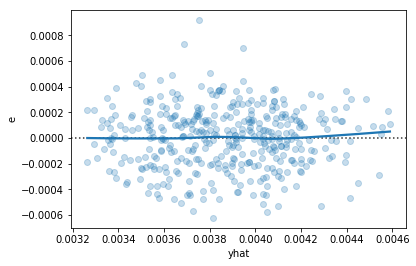

In [1081]:
ef, yhatf = resid_plot(lmf)

In [1082]:
stats.shapiro(ef)

(0.9916356801986694, 0.023285508155822754)

In [1083]:
tstatf, pvalf, _, __ = het_breuschpagan(ef, lmf.model.exog)
print (pvalf)

0.6284897109322464


In [1098]:
lmf.params

const         0.005111
inv           0.000003
ltsz         -0.001772
a_c          -0.000066
f_place      -0.000184
garsz_a      -0.000159
dr           -0.000471
bdrms        -0.000117
hssz_bsemt   -0.000002
hssz_bath    -0.000001
hssz_dr       0.000003
dtype: float64

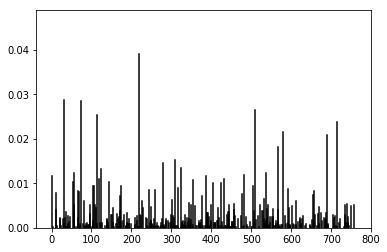

In [1097]:
cooksf = cooks_plot(lmf)

In [1088]:
IQR_final_trans = IQR_final.copy()

In [1089]:
IQR_final_trans['ltsz'] = 1/np.sqrt(IQR_final_trans['ltsz'])

In [1090]:
lmf_trans = sm.OLS(IQR_final_trans['s_p'], sm.add_constant(IQR_final_trans[final_features])).fit()

In [1091]:
lmf_trans.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_p   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     56.05
Date:                Mon, 06 May 2019   Prob (F-statistic):           2.81e-69
Time:                        19:39:59   Log-Likelihood:                 2777.6
No. Observations:                 401   AIC:                            -5533.
Df Residuals:                     390   BIC:                            -5489.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.000     20.839      0.000       0.004       0.004
inv         3.214e-06   9.87e-07      3.258      0.001    1.27e-06    5.15e-06
ltsz           0.0003   5.42e-05      6.064      0.000       0.000       0.000
a_c        -6.296e-05    3.3e-05     -1.908      0.057      -0.000    1.93e-06
f_place       -0.0002    2.7e-05     -6.870      0.000      -0.000      -0.000
garsz_a       -0.0002   5.77e-05     -2.734      0.007      -0.000   -4.43e-05
dr            -0.0005      0.000     -3.829      0.000      -0.001      -0.000
bdrms         -0.0001   2.29e-05     -5.093      0.000      -0.000   -7.16e-05
hssz_bsemt -2.181e-06   4.24e-07     -5.147      0.000   -3.01e-06   -1.35e-06
hssz_bath  -1.173e-06   2.36e-07     -4.962      0.000   -1.64e-06   -7.08e-07
hssz_dr     2.663e-06   1.01e-06      2.649      0.008    6.86e-07    4.64e-06
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.429
Skew:                          -0.019   Prob(JB):                        0.807
Kurtosis:                       3.156   Cond. No.                     4.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

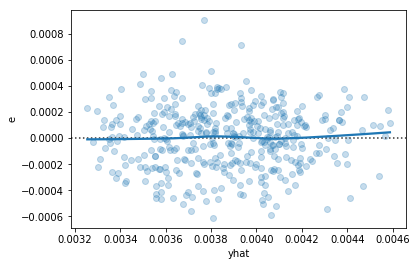

In [1093]:
ef_trans, yhatf_trans = resid_plot(lmf_trans)

In [1094]:
stats.shapiro(ef_trans)

(0.9911574721336365, 0.016898158937692642)

In [1095]:
tstatf_trans, pvalf_trans, _, __ = het_breuschpagan(ef_trans, lmf_trans.model.exog)
print (pvalf_trans)

0.6672381544923571


In [1096]:
print ('RSE trans:', np.sqrt(lmf_trans.scale))

RSE trans: 0.00024075502592898565
